In [1]:
# Utilizes code from:
# https://github.com/VSainteuf/utae-paps
# https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
# https://towardsdatascience.com/understanding-u-net-61276b10f360

In [17]:
#Fill these file paths with the locations on your machine. 
PATH_TO_CODE = 'C:/Users/blake/OneDrive/Desktop/Computer Vision/Project/pastis-benchmark/code' # path to the code folder of the repo
PATH_TO_PASTIS = 'D:/PASTIS'


import sys
sys.path.append(PATH_TO_CODE)

# import the necessary packages
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss
import torch
import torch.nn as nn
import torch.utils.data as data
import torchnet as tnt

from torchmetrics import JaccardIndex

import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib

import tensorflow as tf

import json
import os
import pickle as pkl
import time

cm = matplotlib.colormaps.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

def get_rgb(x, batch_index=0, t_show=1):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x['S2'][batch_index, t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

def get_radar(x, batch_index=0, t_show=6, orbit='D'):
    """Utility function to get a displayable image 
    from a Sentinel-1 time series.
    """
    im = x['S1{}'.format(orbit)][batch_index, t_show].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

In [3]:
from dataloader import PASTIS_Dataset
from collate import pad_collate

In [4]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

def load_image_train(x, y):
   input_image = x
   input_mask = y
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

def load_image_test(x, y):
   input_image = x
   input_mask = y
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

In [5]:
import evaluate

iou_meter = evaluate.load("mean_iou")

In [6]:
def recursive_todevice(x, device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    elif isinstance(x, dict):
        return {k: recursive_todevice(v, device) for k, v in x.items()}
    else:
        return [recursive_todevice(c, device) for c in x]


def prepare_output():
    os.makedirs('output', exist_ok=True)
    for fold in range(1, 6):
        os.makedirs(os.path.join("Fold_{}".format(fold)), exist_ok=True)


def checkpoint(fold, log):
    with open(
        os.path.join('output', "Fold_{}".format(fold), "trainlog.json"), "w"
    ) as outfile:
        json.dump(log, outfile, indent=4)


def save_results(fold, metrics):
    if isinstance(metrics, torch.Tensor):
        metrics = metrics.cpu().numpy()
    with open(
        os.path.join('output', "Fold_{}".format(fold), "test_metrics.json"), "w"
    ) as outfile:
        json.dump(metrics, outfile, indent=4)
    
def iterate(
    model, data_loader, criterion, optimizer=None, mode="train", device=None
):
    loss_meter = tnt.meter.AverageValueMeter()
    t_start = time.time()

    for i, batch in enumerate(data_loader):
        if device is not None:
            batch = recursive_todevice(batch, device)
        (x, dates), y = batch
        y = y.long()
        x = x['S2'][:, 0, range(0,3), :, :].to(device)

        if mode != "train":
            with torch.no_grad():
                out = model(x)
        else:
            optimizer.zero_grad()
            out = model(x)

        loss = criterion(out, y)
        
        if mode == "train":
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            pred = out.argmax(dim=1)
            pred = pred.resize(100, 128, 128)

        iou_meter.add_batch(predictions=pred.detach().cpu().numpy(), references=y.detach().cpu().numpy())
        loss_meter.add(loss.item())

        loss_meter.add(loss.item())

        if (i + 1) % 2 == 0:
            metrics = iou_meter._compute(
                      predictions=pred.cpu(),
                      references=y.cpu(),
                      num_labels=20,
                      ignore_index=255,
                      reduce_labels=False, # we've already reduced the labels ourselves
                  )
            print(
                "Step [{}/{}], Loss: {:.4f}, mIoU {:.2f}".format(
                    i + 1, len(data_loader), loss_meter.value()[0], metrics["mean_iou"]
                )
            )

    t_end = time.time()
    total_time = t_end - t_start
    print("Epoch time : {:.1f}s".format(total_time))
    metrics = {
        "{}_loss".format(mode): loss_meter.value()[0],
        "{}_IoU".format(mode): metrics["mean_iou"],
        "{}_epoch_time".format(mode): total_time,
    }

    return metrics


In [7]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))
	
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
		
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs
	
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures
	
class UNet(Module):
	def __init__(self, encChannels=(3, 16, 32, 64),
		 decChannels=(64, 32, 16),
		 nbClasses=20, retainDim=True,
		 outSize=(128,  128)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize

	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

In [8]:
class EncoderBlock_2(nn.Module):        
    # Consists of Conv -> ReLU -> MaxPool
    def __init__(self, in_chans, out_chans, layers=2, sampling_factor=2, padding="same"):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.encoder.append(nn.Conv2d(in_chans, out_chans, 3, 1, padding=padding))
        self.encoder.append(nn.ReLU())
        for _ in range(layers-1):
            self.encoder.append(nn.Conv2d(out_chans, out_chans, 3, 1, padding=padding))
            self.encoder.append(nn.ReLU())
        self.mp = nn.MaxPool2d(sampling_factor)
    def forward(self, x):
        for enc in self.encoder:
            x = enc(x)
        mp_out = self.mp(x)
        return mp_out, x

class DecoderBlock_2(nn.Module):
    # Consists of 2x2 transposed convolution -> Conv -> relu
    def __init__(self, in_chans, out_chans, layers=2, skip_connection=True, sampling_factor=2, padding="same"):
        super().__init__()
        skip_factor = 1 if skip_connection else 2
        self.decoder = nn.ModuleList()
        self.tconv = nn.ConvTranspose2d(in_chans, in_chans//2, sampling_factor, sampling_factor)

        self.decoder.append(nn.Conv2d(in_chans//skip_factor, out_chans, 3, 1, padding=padding))
        self.decoder.append(nn.ReLU())

        for _ in range(layers-1):
            self.decoder.append(nn.Conv2d(out_chans, out_chans, 3, 1, padding=padding))
            self.decoder.append(nn.ReLU())

        self.skip_connection = skip_connection
        self.padding = padding
    def forward(self, x, enc_features=None):
        x = self.tconv(x)
        if self.skip_connection:
            if self.padding != "same":
                # Crop the enc_features to the same size as input
                w = x.size(-1)
                c = (enc_features.size(-1) - w) // 2
                enc_features = enc_features[:,:,c:c+w,c:c+w]
            x = torch.cat((enc_features, x), dim=1)
        for dec in self.decoder:
            x = dec(x)
        return x

class UNet_2(nn.Module):
    def __init__(self, nclass=1, in_chans=1, depth=5, layers=2, sampling_factor=2, skip_connection=True, padding="same"):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        out_chans = 64
        for _ in range(depth):
            self.encoder.append(EncoderBlock_2(in_chans, out_chans, layers, sampling_factor, padding))
            in_chans, out_chans = out_chans, out_chans*2

        out_chans = in_chans // 2
        for _ in range(depth-1):
            self.decoder.append(DecoderBlock_2(in_chans, out_chans, layers, skip_connection, sampling_factor, padding))
            in_chans, out_chans = out_chans, out_chans//2
        # Add a 1x1 convolution to produce final classes
        self.logits = nn.Conv2d(in_chans, nclass, 1, 1)

    def forward(self, x):
        encoded = []
        for enc in self.encoder:
            x, enc_output = enc(x)
            encoded.append(enc_output)
        x = encoded.pop()
        for dec in self.decoder:
            enc_output = encoded.pop()
            x = dec(x, enc_output)

        # Return the logits
        return self.logits(x)

In [9]:
model = UNet().to(device='cuda:0')
# model = UNet_2(nclass=20, in_chans=3).to('cuda:0')
# initialize loss function and optimizer
optimizer = torch.optim.Adam(model.parameters())
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [10]:
model.load_state_dict(
    torch.load(
        os.path.join(
            'output', "Fold_{}".format(1), "model_fcn.pth.tar"
        )
    )["state_dict"]
)

<All keys matched successfully>

In [11]:
fold_sequence = [
    [[1, 2, 3], [4], [5]],
    [[2, 3, 4], [5], [1]],
    [[3, 4, 5], [1], [2]],
    [[4, 5, 1], [2], [3]],
    [[5, 1, 2], [3], [4]],
]

np.random.seed(42)
torch.manual_seed(42)
prepare_output()
device = torch.device('cuda:0')
batch_size = 100

for fold, (train_folds, val_fold, test_fold) in enumerate(fold_sequence):
    # Dataset definition
    dt_args = dict(
        folder='D:/PASTIS',
        norm=True,
        target="semantic",
        sats=["S2"],
    )

    dt_train = PASTIS_Dataset(**dt_args, folds=train_folds)
    dt_val = PASTIS_Dataset(**dt_args, folds=val_fold)
    dt_test = PASTIS_Dataset(**dt_args, folds=test_fold)

    collate_fn = pad_collate
    train_loader = data.DataLoader(
        dt_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn,
    )
    val_loader = data.DataLoader(
        dt_val,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn,
    )
    test_loader = data.DataLoader(
        dt_test,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn,
    )

    print(
        "Train {}, Val {}, Test {}".format(len(dt_train), len(dt_val), len(dt_test))
    )

    # Training loop
    trainlog = {}
    best_mIoU = 0

    weights = torch.ones(20, device=device).float()
    criterion = CrossEntropyLoss(weight=weights)

    for epoch in range(1, 20):
        print("EPOCH {}/{}".format(epoch, 20))

        model.train()
        train_metrics = iterate(
            model,
            data_loader=train_loader,
            criterion=criterion,
            optimizer=optimizer,
            mode="train",
            device=device,
        )
        print("Validation . . . ")
        model.eval()
        val_metrics = iterate(
            model,
            data_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            mode="val",
            device=device,
        )

        print(
            "Loss {:.4f}, IoU {:.4f}".format(
                val_metrics["val_loss"],
                val_metrics["val_IoU"],
            )
        )

        trainlog[epoch] = {**train_metrics, **val_metrics}
        checkpoint(fold + 1, trainlog)
        if val_metrics["val_IoU"] >= best_mIoU:
            best_mIoU = val_metrics["val_IoU"]
            torch.save(
                {
                    "epoch": epoch,
                    "state_dict": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                },
                os.path.join(
                    'output', "Fold_{}".format(fold + 1), "model_fcn.pth.tar"
                ),
            )

    print("Testing best epoch . . .")
    model.load_state_dict(
        torch.load(
            os.path.join(
                'output', "Fold_{}".format(fold + 1), "model_fcn.pth.tar"
            )
        )["state_dict"]
    )
    model.eval()

    test_metrics = iterate(
        model,
        data_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        mode="test",
        device=device,
    )
    print(
        "Loss {:.4f},  IoU {:.4f}".format(
            test_metrics["test_loss"],
            test_metrics["test_IoU"]
        )
    )
    save_results(fold + 1, test_metrics)

Reading patch metadata . . .
Done.
Dataset ready.
Reading patch metadata . . .
Done.
Dataset ready.
Reading patch metadata . . .
Done.
Dataset ready.
Train 1455, Val 482, Test 496
EPOCH 1/20


c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\datasets\features\image.py:341: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Step [2/14], Loss: 2.3012, mIoU 0.02
Step [4/14], Loss: 2.1463, mIoU 0.02
Step [6/14], Loss: 2.1417, mIoU 0.02
Step [8/14], Loss: 2.1422, mIoU 0.02
Step [10/14], Loss: 2.1155, mIoU 0.02
Step [12/14], Loss: 2.1079, mIoU 0.02
Step [14/14], Loss: 2.0956, mIoU 0.02
Epoch time : 649.6s
Validation . . . 
Step [2/4], Loss: 1.9997, mIoU 0.02
Step [4/4], Loss: 2.0223, mIoU 0.02
Epoch time : 176.8s
Loss 2.0223, IoU 0.0209
EPOCH 2/20
Step [2/14], Loss: 1.9972, mIoU 0.02
Step [4/14], Loss: 1.9901, mIoU 0.02
Step [6/14], Loss: 1.9878, mIoU 0.02
Step [8/14], Loss: 1.9928, mIoU 0.02
Step [10/14], Loss: 1.9993, mIoU 0.02
Step [12/14], Loss: 1.9947, mIoU 0.02
Step [14/14], Loss: 1.9969, mIoU 0.02
Epoch time : 684.6s
Validation . . . 
Step [2/4], Loss: 1.9580, mIoU 0.02
Step [4/4], Loss: 1.9686, mIoU 0.02
Epoch time : 175.0s
Loss 1.9686, IoU 0.0206
EPOCH 3/20
Step [2/14], Loss: 1.9441, mIoU 0.02
Step [4/14], Loss: 1.9946, mIoU 0.02
Step [6/14], Loss: 1.9872, mIoU 0.02
Step [8/14], Loss: 1.9941, mIoU 0.0

c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\datasets\features\image.py:341: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Step [2/14], Loss: 1.9069, mIoU 0.04
Step [4/14], Loss: 1.9078, mIoU 0.04
Step [6/14], Loss: 1.8844, mIoU 0.03
Step [8/14], Loss: 1.8864, mIoU 0.04
Step [10/14], Loss: 1.8919, mIoU 0.03
Step [12/14], Loss: 1.8900, mIoU 0.02
Step [14/14], Loss: 1.8876, mIoU 0.04
Epoch time : 648.3s
Validation . . . 
Step [2/4], Loss: 1.9111, mIoU 0.04
Step [4/4], Loss: 1.9322, mIoU 0.04
Epoch time : 180.5s
Loss 1.9322, IoU 0.0418
EPOCH 2/20
Step [2/14], Loss: 1.8981, mIoU 0.04
Step [4/14], Loss: 1.8686, mIoU 0.03
Step [6/14], Loss: 1.8485, mIoU 0.04
Step [8/14], Loss: 1.8656, mIoU 0.04
Step [10/14], Loss: 1.8618, mIoU 0.04
Step [12/14], Loss: 1.8693, mIoU 0.04
Step [14/14], Loss: 1.8653, mIoU 0.04
Epoch time : 648.1s
Validation . . . 
Step [2/4], Loss: 1.9084, mIoU 0.04
Step [4/4], Loss: 1.8945, mIoU 0.04
Epoch time : 179.9s
Loss 1.8945, IoU 0.0372
EPOCH 3/20
Step [2/14], Loss: 1.8871, mIoU 0.04
Step [4/14], Loss: 1.8734, mIoU 0.03
Step [6/14], Loss: 1.8624, mIoU 0.04
Step [8/14], Loss: 1.8527, mIoU 0.0

c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\datasets\features\image.py:341: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Step [2/14], Loss: 1.8100, mIoU 0.03
Step [4/14], Loss: 1.8322, mIoU 0.05
Step [6/14], Loss: 1.8502, mIoU 0.04
Step [8/14], Loss: 1.8504, mIoU 0.04
Step [10/14], Loss: 1.8436, mIoU 0.04
Step [12/14], Loss: 1.8424, mIoU 0.05
Step [14/14], Loss: 1.8471, mIoU 0.05
Epoch time : 652.0s
Validation . . . 
Step [2/4], Loss: 1.8380, mIoU 0.04
Step [4/4], Loss: 1.8400, mIoU 0.04
Epoch time : 178.2s
Loss 1.8400, IoU 0.0407
EPOCH 2/20
Step [2/14], Loss: 1.8637, mIoU 0.05
Step [4/14], Loss: 1.8220, mIoU 0.04
Step [6/14], Loss: 1.8247, mIoU 0.04
Step [8/14], Loss: 1.8262, mIoU 0.05
Step [10/14], Loss: 1.8251, mIoU 0.04
Step [12/14], Loss: 1.8196, mIoU 0.05
Step [14/14], Loss: 1.8339, mIoU 0.04
Epoch time : 649.8s
Validation . . . 
Step [2/4], Loss: 1.8582, mIoU 0.05
Step [4/4], Loss: 1.8427, mIoU 0.04
Epoch time : 178.3s
Loss 1.8427, IoU 0.0435
EPOCH 3/20
Step [2/14], Loss: 1.8014, mIoU 0.04
Step [4/14], Loss: 1.8462, mIoU 0.04
Step [6/14], Loss: 1.8424, mIoU 0.04
Step [8/14], Loss: 1.8542, mIoU 0.0

c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\datasets\features\image.py:341: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Step [2/14], Loss: 1.7637, mIoU 0.04
Step [4/14], Loss: 1.8023, mIoU 0.04
Step [6/14], Loss: 1.8034, mIoU 0.04
Step [8/14], Loss: 1.8226, mIoU 0.04
Step [10/14], Loss: 1.8241, mIoU 0.04
Step [12/14], Loss: 1.8211, mIoU 0.05
Step [14/14], Loss: 1.8200, mIoU 0.04
Epoch time : 653.4s
Validation . . . 
Step [2/4], Loss: 1.8213, mIoU 0.04
Step [4/4], Loss: 1.8266, mIoU 0.05
Epoch time : 178.2s
Loss 1.8266, IoU 0.0468
EPOCH 2/20
Step [2/14], Loss: 1.7847, mIoU 0.04
Step [4/14], Loss: 1.7741, mIoU 0.05
Step [6/14], Loss: 1.7968, mIoU 0.05
Step [8/14], Loss: 1.8022, mIoU 0.04
Step [10/14], Loss: 1.8232, mIoU 0.04
Step [12/14], Loss: 1.8057, mIoU 0.05
Step [14/14], Loss: 1.8122, mIoU 0.05
Epoch time : 651.8s
Validation . . . 
Step [2/4], Loss: 1.8427, mIoU 0.05
Step [4/4], Loss: 1.8255, mIoU 0.05
Epoch time : 178.7s
Loss 1.8255, IoU 0.0476
EPOCH 3/20
Step [2/14], Loss: 1.8275, mIoU 0.04
Step [4/14], Loss: 1.8040, mIoU 0.04
Step [6/14], Loss: 1.8051, mIoU 0.05
Step [8/14], Loss: 1.8069, mIoU 0.0

c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\datasets\features\image.py:341: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Step [2/14], Loss: 1.8497, mIoU 0.05
Step [4/14], Loss: 1.8362, mIoU 0.04
Step [6/14], Loss: 1.8448, mIoU 0.04
Step [8/14], Loss: 1.8215, mIoU 0.05
Step [10/14], Loss: 1.8186, mIoU 0.05
Step [12/14], Loss: 1.8161, mIoU 0.04
Step [14/14], Loss: 1.8229, mIoU 0.04
Epoch time : 656.1s
Validation . . . 
Step [2/4], Loss: 1.7718, mIoU 0.05
Step [4/4], Loss: 1.8120, mIoU 0.05
Epoch time : 177.0s
Loss 1.8120, IoU 0.0461
EPOCH 2/20
Step [2/14], Loss: 1.8815, mIoU 0.04
Step [4/14], Loss: 1.8264, mIoU 0.04
Step [6/14], Loss: 1.8195, mIoU 0.05
Step [8/14], Loss: 1.8253, mIoU 0.04
Step [10/14], Loss: 1.8222, mIoU 0.05
Step [12/14], Loss: 1.8162, mIoU 0.04
Step [14/14], Loss: 1.8226, mIoU 0.05
Epoch time : 655.3s
Validation . . . 
Step [2/4], Loss: 1.8572, mIoU 0.05
Step [4/4], Loss: 1.7929, mIoU 0.05
Epoch time : 176.3s
Loss 1.7929, IoU 0.0490
EPOCH 3/20
Step [2/14], Loss: 1.8393, mIoU 0.04
Step [4/14], Loss: 1.8130, mIoU 0.04
Step [6/14], Loss: 1.8250, mIoU 0.04
Step [8/14], Loss: 1.8082, mIoU 0.0

In [13]:
fold_sequence = [
    [[5, 1, 2], [3], [4]]
]

for fold, (train_folds, val_fold, test_fold) in enumerate(fold_sequence):
    dt_args = dict(
        folder='D:/PASTIS',
        norm=True,
        target="semantic",
        sats=["S2"],
    )

    dt_train = PASTIS_Dataset(**dt_args, folds=train_folds)
    dt_test = PASTIS_Dataset(**dt_args, folds=test_fold)

    collate_fn = pad_collate
    train_loader = data.DataLoader(
        dt_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn,
    )

Reading patch metadata . . .
Done.
Dataset ready.
Reading patch metadata . . .
Done.
Dataset ready.


In [14]:
model.load_state_dict(
    torch.load(
        os.path.join(
            'output', "Fold_5", "model_fcn.pth.tar"
        )
    )["state_dict"]
)

<All keys matched successfully>

In [15]:
from matplotlib import pyplot as plt

for idx, batch in enumerate(train_loader):
    break
# idx, batch = train_loader.__iter__().__next__()
(x, dates), y = batch

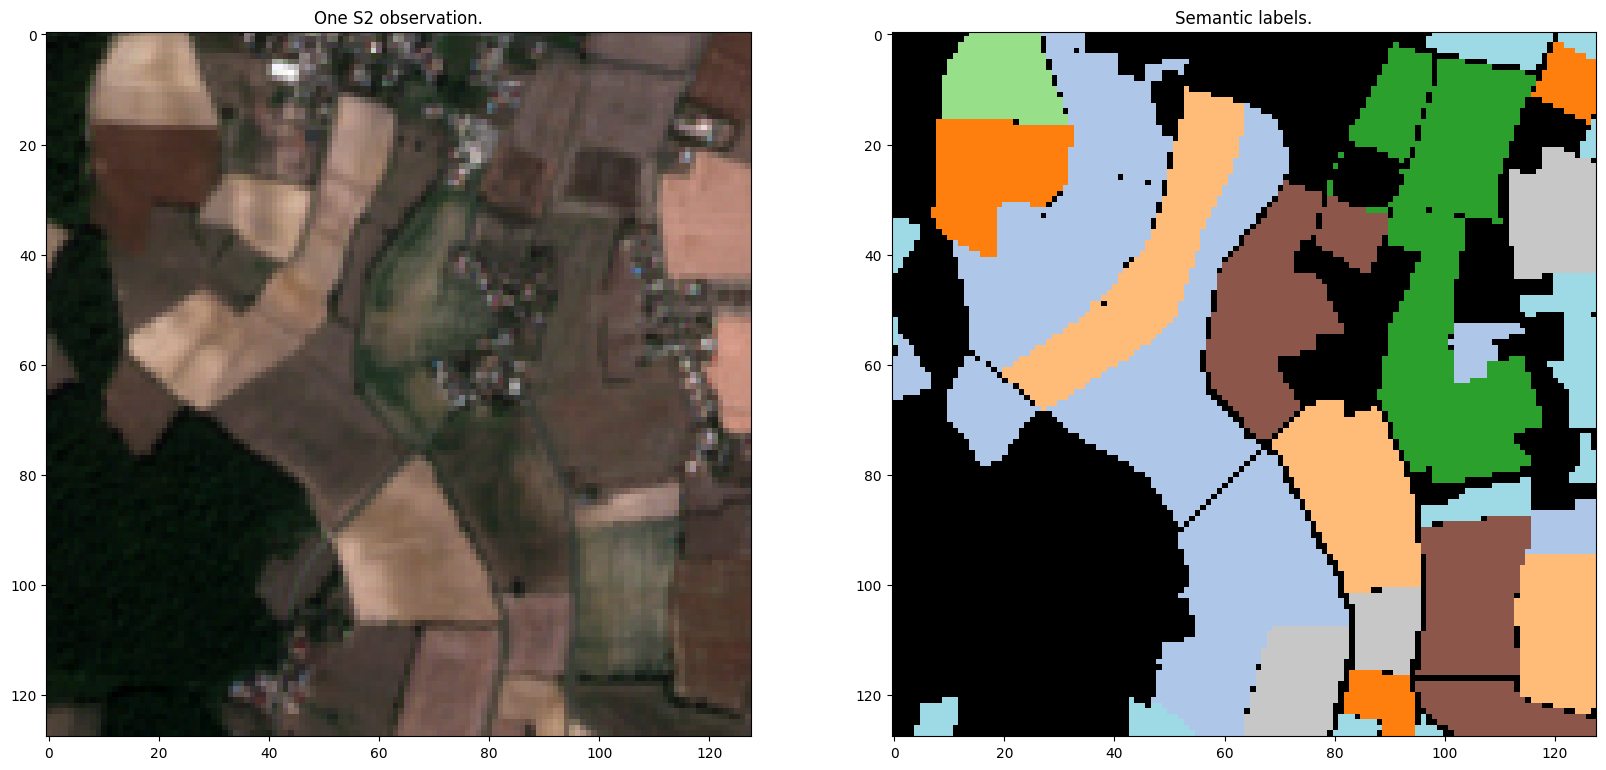

In [18]:
bid = 1 # Which element of the batch to plot

fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(y[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation.')
axes[1].set_title('Semantic labels.')

plt.show()

In [20]:
im = x['S2'][bid, 1, [2,1,0]].to(device)
im = im.resize(1, 3, 128, 128)

# forward pass
with torch.no_grad():
  outputs = model(im)

c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [32]:
outputs.shape

torch.Size([1, 20, 128, 128])

In [33]:
labels = y.long().to(device)

In [34]:
with torch.no_grad():
        # upsampled_logits = nn.functional.interpolate(outputs, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = outputs.argmax(dim=1)

In [35]:
predicted.squeeze().shape

torch.Size([128, 128])

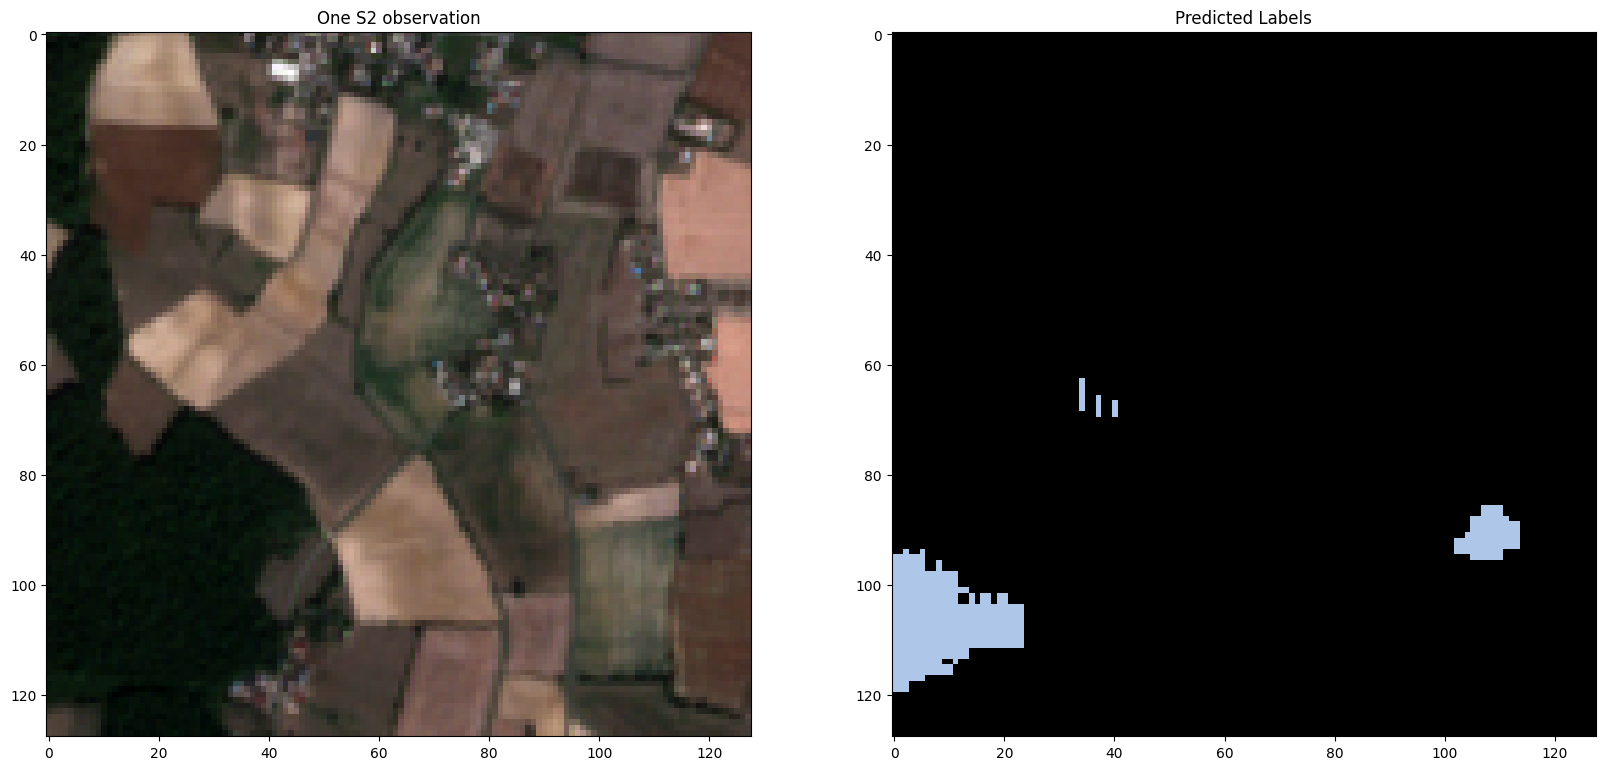

In [36]:
fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(predicted.squeeze().cpu(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation')
axes[1].set_title('Predicted Labels')

plt.show()

In [37]:
test_loader = data.DataLoader(
    dt_test,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn,
)

In [38]:
for idx, batch in enumerate(test_loader):
    break

(x, dates), y = batch

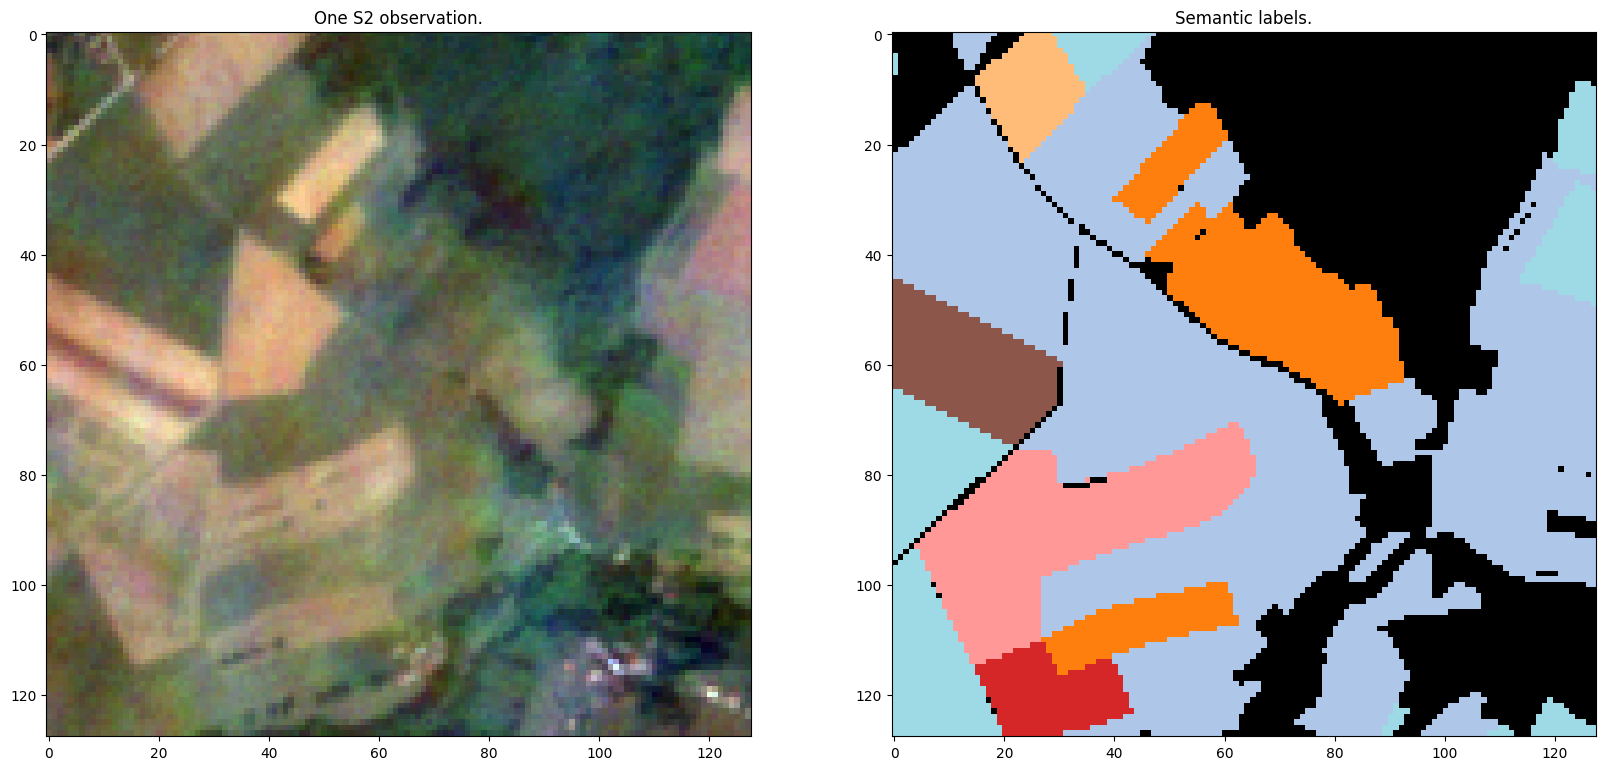

In [39]:
bid = 3 # Which element of the batch to plot

fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(y[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation.')
axes[1].set_title('Semantic labels.')

plt.show()

In [40]:
im = x['S2'][bid, 1, [2,1,0]].to(device)
im = im.resize(1, 3, 128, 128)

# forward pass
with torch.no_grad():
  outputs = model(im)

c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [41]:
labels = y.long().to(device)

In [42]:
with torch.no_grad():
        # upsampled_logits = nn.functional.interpolate(outputs, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = outputs.argmax(dim=1)

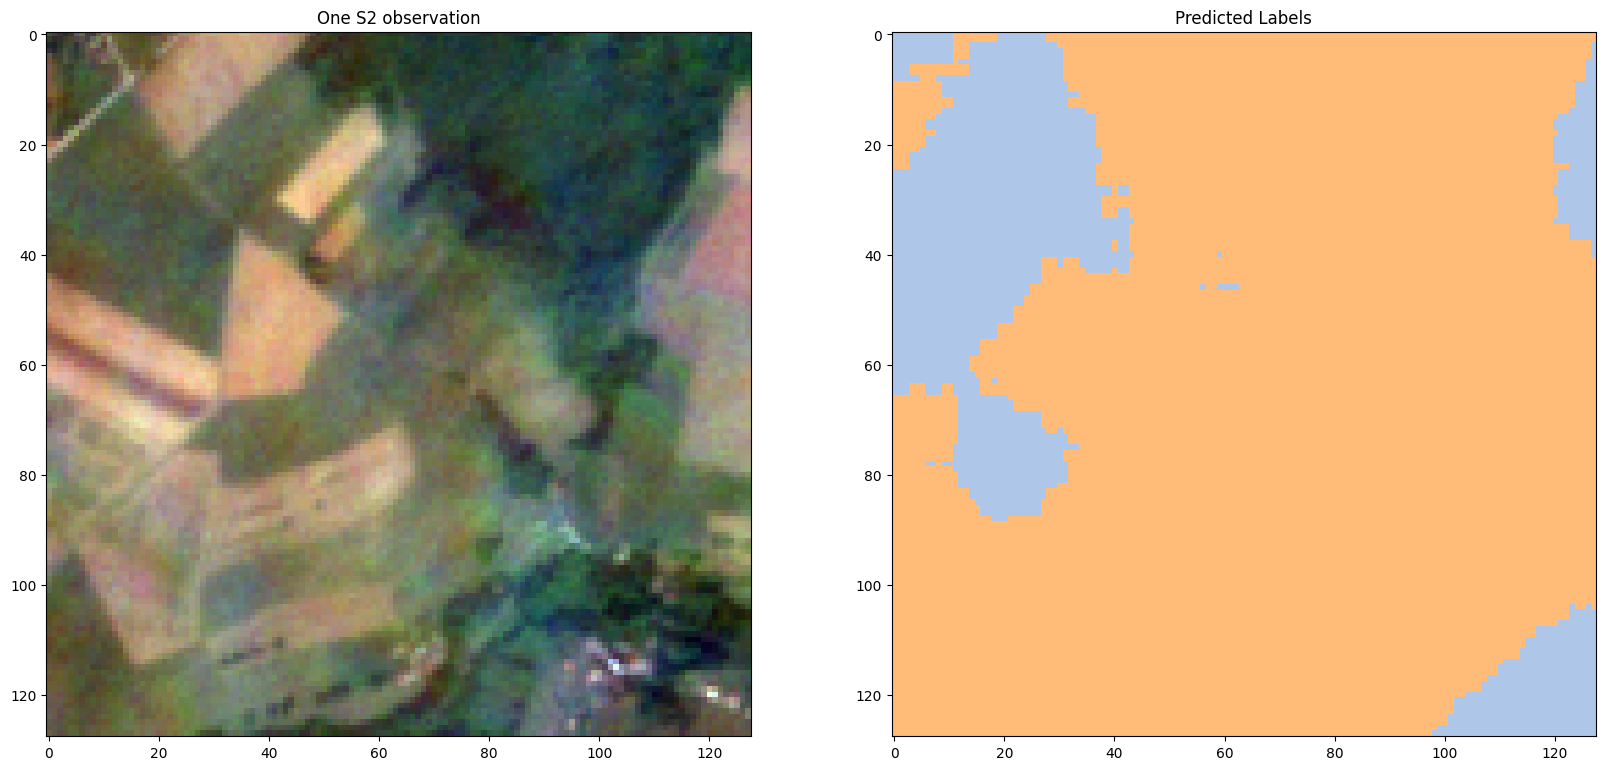

In [43]:
fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(predicted.squeeze().cpu(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation')
axes[1].set_title('Predicted Labels')

plt.show()